# **Introducción a Redes Neuronales --- Tarea 4: Perceptrón Multicapa**

*Autor: David Segura Carnet #13-11341*,
05/07/2020

### Parte 1: Implementación Perceptrón Multicapa

Implemente su propio perceptrón multicapas para que tenga una capa oculta con un número $n$ de neuronas en la capa oculta y $k$ neuronas en la capa de salida. $n$ y $k$ son parámetros de su red (función). Usted puede emplear el lenguage de programación de su preferencia. Entregar el código con una documentación mínima. En esta tarea usted volverá sobre la clasificación de la base de datos MNIST usada en las tareas anteriores. Especificaciones:
* capa de entrada: 784 unidades.
* capa de salida: 10 unidades.
* funciones de activación: sigmoide en todas las capas.
* respuestas deseadas: 0.9 para la unidad que representa la clase correcta y 0.1 en caso contrario.
* preprocesamiento: Escalar la entrada a valores en [0,1]
* algoritmo de entrenamiento: descenso de gradiente estocástico con momentum
para 50 épocas.
* parámetros de aprendizaje: $η = 0.1$ (tasa de aprendizaje) y $α = 0.9$. (parámetro de momentum)
* inicialización de pesos: aleatoria en el intervalo [-0.05, 0.05]

In [ ]:
import numpy as np
import random
import time

class MultilayerPerceptron():
  '''
  [Clase MultilayerPerceptron]
    Representara la red completa donde se inicializaran con valores generalizados
    para ser utilizados en las capas que la componen.

    INIT: lowRandom   -> Valor minimo del rango de los valores a generar en la matriz de pesos
          highRandom  -> Valor maximo del rango de los valores a generar en la matriz de pesos
          etha        -> Tasa de aprendizaje
          momentum    -> Parametro momentum usado para mejorar el algoritmo en cuanto a actualizacion
          maxEpochs   -> Limite maximo de epocas a entrenar
          layers      -> Arreglo donde se almacenaran las capas de la red
  '''
  def __init__(self, lowRandom, highRandom, etha, momentum, maxEpochs):
    self.lowRandom = lowRandom
    self.highRandom = highRandom
    self.etha = etha
    self.momentum = momentum
    self.maxEpochs = maxEpochs
    self.layers = []
  
  class Layer:
    '''
    [Clase Layer]
      Representara una capa C, bien sea una capa oculta o una capa de salida. Donde cada capa almacenara
      dos elementos, los pesos correspondiente a las capa y la funcion de activacion
      
      INIT: w                   -> Matriz de pesos correpondiente a la capa incluyendo el sesgo
            activationFunction  -> Funcion activacion a utilizar para la capa
            beforeIterationW    -> Variacion de peso de la iteracion anterior
    '''
    def __init__(self, numOfNeurons, dimData_with_bias, lowRandom, highRandom, activationFunction, derivateFunction):
      self.w = np.random.uniform(low=lowRandom, high=highRandom, size=(numOfNeurons,dimData_with_bias))
      self.activationFunction = activationFunction
      self.derivateFunction = derivateFunction
      self.beforeIterationW = 0
    
    def propagation(self, V, activationFunction):
      '''
        {Funcion propagation}
          Se le incluye al vector de los datos el valor de 1 para la representacion del sesgo, y
          luego se realiza el producto punto entre la matriz de pesos y el vector de datos, donde
          despues se realiza la activacion y se retorna la salida "y"
        
        INPUT:  V                   -> Vector con los patrones a procesar
                activationFunction  -> Funcion activacion a utilizar para la capa
        
        OUTPUT: [float] -> Vector resultante de la propagacion
      '''
      estimulo = np.dot(self.w, V)
      return [activationFunction(i) for i in estimulo]
    
    def update(self, gradient, V, momentum, etha):
      '''
      {Funcion update}
        Metodo que actualiza los pesos con la mejora en el algoritmo que consiste en considerar la
        informacion de la iteracion anterior y multiplicarlo por un parametro (momentum)
      INPUT:  gradient   -> Son los gradientes locales de las neuronas de la capa
              V          -> Vector con los patrones a procesar
              momentum   -> Parametro momentum usado para mejorar el algoritmo en cuanto a actualizacion
              etha       -> Tasa de aprendizaje
      '''
      temp = [x.copy() for x in self.w]
      self.w += momentum * (self.w - self.beforeIterationW)  + etha * np.outer(gradient, V)
      self.beforeIterationW = temp
  
  def createLayer(self, activationFunction, derivateFunction, numOfNeurons, dimData_with_bias=None):
    '''
      {Funcion createLayer}
        Metodo que se encarga de crear una capa para la red.
      
      INPUT:  activationFunction  -> Funcion activacion a utilizar para la capa
              derivationFunction  -> Funcion derivada de activacion a utilizar en los gradientes
              numOfNeurons        -> Numero de neuronas a implementar en la capa
              dimData_with_bias   -> Dimension del patron de entrada, que por defecto es None, esto
                                     porque para la primera capa es necesario. En cuanto las demas
                                     capas se puede obtener este dato de la ultima capa agregada
    '''
    if dimData_with_bias == None:
      dimData_with_bias = len(self.layers[-1].w) + 1
    self.layers.append(self.Layer(numOfNeurons, dimData_with_bias, self.lowRandom, self.highRandom, activationFunction, derivateFunction))
  
  def trainingMain(self, X, X_test, d_function, scale, scale_soft):
    '''
      {Funcion trainingMain}
        Se inicializa el entrenamiento de la red, siguiendo un orden aleatorio para la escogencia
        de los patrones.
      INPUT:  X                   -> Matriz con los datos de entrenamiento a procesar
              X_test              -> Matriz con los datos de prueba a validar
              d_function          -> Funcion que retorna el vector de valor esperado de un dato
              scale               -> Funcion para escalar los resultados de "y" con restriccion Hard
              scale_soft          -> Funcion para escalar los resultados de "y" con restriccion Soft

      OUTPUT: log_precision            -> Arreglo con el historial de la precision de la red con
                                          restriccion Hard y datos de entrenamiento
              log_precision_soft       -> Arreglo con el historial de la precision de la red con
                                          restriccion Soft y datos de entrenamiento
              log_precision_test       -> Arreglo con el historial de la precision de la red con
                                          restriccion Hard y datos de validacion
              log_precision_test_soft  -> Arreglo con el historial de la precision de la red con
                                          restriccion Soft y datos de validacion
              log_emc                  -> Arreglo con el historial del EMC de los datos de entrenamiento
              log_emc_test             -> Arreglo con el historial del EMC de los datos de validacion
    '''
    i = 1
    log_precision = [] # Restriccion hard (datos de entrenamiento)
    log_precision_soft = [] # Restriccion soft (datos de entrenamiento)
    log_emc = []  # EMC (datos de entrenamiento)
    log_precision_test = [] # Restriccion hard (datos de validacion)
    log_precision_test_soft = [] # Restriccion soft (datos de validacion)
    log_emc_test = []  # EMC (datos de validacion)
    while i <= self.maxEpochs:
      print("Epoca " + str(i))
      np.random.shuffle(X)
      emc = 0
      for x in X:
        x_bias = np.insert(x[1:], 0, 1, axis=0)
        d = d_function(x[0])
        self.__training(x_bias, d)
      i += 1
      # Restriccion Hard
      precision, emc = self.predict(X, d_function, scale)
      precision_test, emc_test = self.predict(X_test, d_function, scale)
      log_precision.append(precision)
      log_precision_test.append(precision_test)
      # Restriccion Soft
      precision_soft = self.predict(X, d_function, scale_soft)[0]
      precision_test_soft = self.predict(X_test, d_function, scale_soft)[0]
      log_precision_soft.append(precision_soft)
      log_precision_test_soft.append(precision_test_soft)
      # EMC
      log_emc.append(emc)
      log_emc_test.append(emc_test)
    return log_precision, log_precision_soft, log_precision_test, log_precision_test_soft, log_emc, log_emc_test
  
  def __training(self, V, d, layerIndex = 0):
    '''
      {Funcion training}
        Se realiza el entrenamiento de la red mediante la actualizacion de los pesos usando el
        descenso de gradiente estocástico con momentum
      INPUT:  X           -> Matriz con los datos a procesar
              d           -> Valor esperado de un dato
              layerIndex  -> Indice que indicara la capa en la que nos encontramos
      
      OUTPUT: [float]     -> Gradiente local de la capa
    '''
    actual_layer = self.layers[layerIndex]
    y = actual_layer.propagation(V, actual_layer.activationFunction)
    if layerIndex == len(self.layers) - 1:
      # Capa de Salida
      error = np.subtract(d, y)
      gradient = error * actual_layer.propagation(V, actual_layer.derivateFunction)
      actual_layer.update(gradient, V, self.momentum, self.etha)
      return np.dot(gradient, actual_layer.w)
    else:
      y_bias = np.insert(y, 0, 1, axis=0)
      gradient_alpha = self.__training(y_bias, d, layerIndex + 1)
      gradient = actual_layer.propagation(V, actual_layer.derivateFunction) * gradient_alpha[1:]
      actual_layer.update(gradient, V, self.momentum, self.etha)
      return np.dot(gradient, actual_layer.w)

  def predict(self, X, d, scale):
    '''
      {Funcion predict}
        Se realiza la prediccion de los datos usando la funcion propagacion y retornara la 
        precision de la red en clasificar los datos.
      INPUT:  X                   -> Matriz con los datos a procesar
              d                   -> Funcion de  los valores esperados de un dato
              scale               -> Funcion para escalar los resultados de y
      
      OUTPUT: float, float        -> Valor correspondiente a la precision de la red y al error 
                                     medio cuadratico
    '''
    counter = 0
    emc = 0
    actual_layer = self.layers
    for x in X:
      y = x[1:]
      layerIndex = 0
      while layerIndex < len(actual_layer):
        y = actual_layer[layerIndex].propagation(np.insert(y, 0, 1, axis=0), actual_layer[layerIndex].activationFunction)
        layerIndex += 1
      error = np.subtract(d(x[0]), y)
      emc += np.dot(error, error) / 2
      if np.array_equal(scale(y), d(x[0])) == False:
        counter += 1
    return 100 * (len(X) - counter) / len(X), emc / len(X)

In [ ]:
from math import exp

def logistic(x, alpha=1):
  '''
    {Funcion logistic}
      Realiza el calculo de la funcion logistica
    INPUT:  x      -> Valor a calcular
            alpha  -> Parametro dentro la funcion con valor defecto 1

    OUTPUT: float  -> Resultado de aplicar la funcion con rango en [0,1]
  '''
  return 1 / (1+exp(-alpha*x))

def derivateLogistic(x, alpha=1):
  '''
    {Funcion logistic}
      Realiza el calculo de la funcion logistica derivada
    INPUT:  x      -> Valor a calcular
            alpha  -> Parametro dentro la funcion con valor defecto 1

    OUTPUT: float  -> Resultado de aplicar la funcion con rango en [0,1]
  '''
  return alpha*logistic(x)*(1-logistic(x))

def d_function(x):
  '''
    {Funcion d_function}
      Representa el valor esperado dentro de la red
    INPUT:  x      -> Representacion en numero

    OUTPUT: [int]  -> Representacion en vector
  '''
  value = [0,0,0,0,0,0,0,0,0,0]
  value[int(x)] = 1
  return value

def d_scale(Y):
  '''
    {Funcion d_scale}
      Restringe el resultado obtenido de la red y lo escala a
      valores comparables con el valor esperado, donde la restriccion
      la categorizamos como hard por su definicion
    INPUT:  Y      -> Vector con el resultado obtenido de la red

    OUTPUT: [int]  -> Vector con la representacion escalada
  '''
  vector = []
  for y in Y:
    if y <= 0.1:
      vector.append(0)
    elif y >= 0.9:
      vector.append(1)
    else:
      vector.append(y)
  return vector

def d_scale_soft(Y):
  '''
    {Funcion d_scale_soft}
      Restringe el resultado obtenido de la red y lo escala a
      valores comparables con el valor esperado, donde la restriccion
      la categorizamos como soft por su definicion, la misma usada
      para el adaline
    INPUT:  Y      -> Vector con el resultado obtenido de la red

    OUTPUT: [int]  -> Vector con la representacion escalada
  '''
  vector = [0,0,0,0,0,0,0,0,0,0]
  index = np.where(Y == np.amax(Y))
  vector[index[0][0]] = 1
  return vector


In [ ]:
from google.colab import drive

# En caso de no usar Google Colab, eliminar la importacion de la libreria y el mount,
# Y modificar las rutas correspondientes de los archivos a cargar
drive.mount('/content/drive')

path_train = '/content/drive/My Drive/RNA/Tarea 2/mnist_train.csv'
path_test = '/content/drive/My Drive/RNA/Tarea 2/mnist_test.csv'

# Cargamos los datos y de una vez los escalamos dividiendo por 255
data_train = np.loadtxt(open(path_train, "rb"), delimiter=",", skiprows=0)
data_train = np.concatenate((np.transpose([data_train[0:,0]]), data_train[0:,1:]/255), axis=1)
data_test = np.loadtxt(open(path_test, "rb"), delimiter=",", skiprows=0)
data_test = np.concatenate((np.transpose([data_test[0:,0]]), data_test[0:,1:]/255), axis=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Parte 2: Experimento 1
Realice su entrenamiento variando el numero de unidades ocultas con n = 20, 50, 100. Incluya el sesgo en cada nodo de la red. Grafique el error de entrenamiento y de validacion. Discuta el efecto del numero de neuronas en el error de entrenamiento y sobre la validacion. Compare los resultados con las tareas anteriores

Epoca  1
Epoca  2
Epoca  3
Epoca  4
Epoca  5
Epoca  6
Epoca  7
Epoca  8
Epoca  9
Epoca  10
Epoca  11
Epoca  12
Epoca  13
Epoca  14
Epoca  15
Epoca  16
Epoca  17
Epoca  18
Epoca  19
Epoca  20
Epoca  21
Epoca  22
Epoca  23
Epoca  24
Epoca  25
Epoca  26
Epoca  27
Epoca  28
Epoca  29
Epoca  30
Epoca  31
Epoca  32
Epoca  33
Epoca  34
Epoca  35
Epoca  36
Epoca  37
Epoca  38
Epoca  39
Epoca  40
Epoca  41
Epoca  42
Epoca  43
Epoca  44
Epoca  45
Epoca  46
Epoca  47
Epoca  48
Epoca  49
Epoca  50
>>> ETHA 0.1, N = 20 y MOMENTUM = 0.9
Maxima Precision Alcanzada Training Hard 89.27
Maxima Precision Alcanzada Training Soft 95.34666666666666


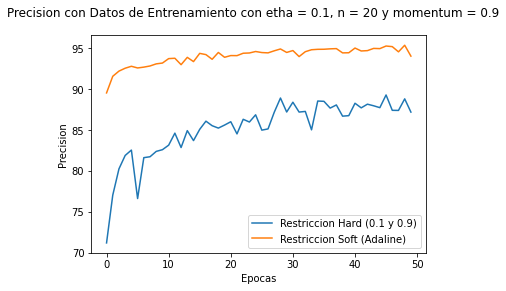

Maxima Precision Alcanzada Test Hard 88.22
Maxima Precision Alcanzada Test Soft 94.19


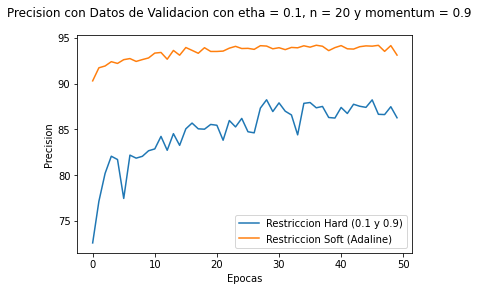

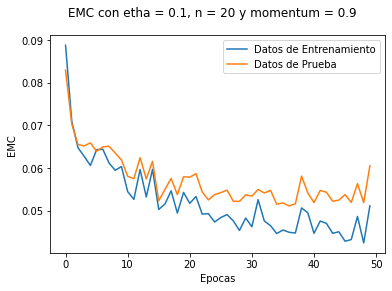

In [ ]:
import matplotlib.pyplot as plt

rna_0_1_20 = MultilayerPerceptron(-0.05, 0.05, 0.1, 0.9, 50)
rna_0_1_20.createLayer(logistic, derivateLogistic, 20, len(data_train[0]))
rna_0_1_20.createLayer(logistic, derivateLogistic, 10)
h_train, s_train, h_test, s_test, emc_train, emc_test = rna_0_1_20.trainingMain(data_train, data_test, d_function, d_scale, d_scale_soft)

#Plot Comparacion de Restricciones para Datos de Entrenamiento
print('>>> ETHA 0.1, N = 20 y MOMENTUM = 0.9')
maxPrecision_ht = np.amax(h_train)
print('Maxima Precision Alcanzada Training Hard', maxPrecision_ht)
maxPrecision_st = np.amax(s_train)
print('Maxima Precision Alcanzada Training Soft', maxPrecision_st)
plt.ylabel("Precision")
plt.xlabel("Epocas")
plt.suptitle('Precision con Datos de Entrenamiento con etha = 0.1, n = 20 y momentum = 0.9')
plt.plot(h_train, label = 'Restriccion Hard (0.1 y 0.9)')
plt.plot(s_train, label = 'Restriccion Soft (Adaline)')
plt.legend()
plt.show()

#Plot Comparacion de Restricciones para Datos de Validacion
maxPrecision_htt = np.amax(h_test)
print('Maxima Precision Alcanzada Test Hard', maxPrecision_htt)
maxPrecision_stt = np.amax(s_test)
print('Maxima Precision Alcanzada Test Soft', maxPrecision_stt)
plt.ylabel("Precision")
plt.xlabel("Epocas")
plt.suptitle('Precision con Datos de Validacion con etha = 0.1, n = 20 y momentum = 0.9')
plt.plot(h_test, label = 'Restriccion Hard (0.1 y 0.9)')
plt.plot(s_test, label = 'Restriccion Soft (Adaline)')
plt.legend()
plt.show()

#Plot Comparacion de EMC
plt.ylabel("EMC")
plt.xlabel("Epocas")
plt.suptitle('EMC con etha = 0.1, n = 20 y momentum = 0.9')
plt.plot(emc_train, label = 'Datos de Entrenamiento')
plt.plot(emc_test, label = 'Datos de Prueba')
plt.legend()
plt.show()

Epoca 1
Epoca 2
Epoca 3
Epoca 4
Epoca 5
Epoca 6
Epoca 7
Epoca 8
Epoca 9
Epoca 10
Epoca 11
Epoca 12
Epoca 13
Epoca 14
Epoca 15
Epoca 16
Epoca 17
Epoca 18
Epoca 19
Epoca 20
Epoca 21
Epoca 22
Epoca 23
Epoca 24
Epoca 25
Epoca 26
Epoca 27
Epoca 28
Epoca 29
Epoca 30
Epoca 31
Epoca 32
Epoca 33
Epoca 34
Epoca 35
Epoca 36
Epoca 37
Epoca 38
Epoca 39
Epoca 40
Epoca 41
Epoca 42
Epoca 43
Epoca 44
Epoca 45
Epoca 46
Epoca 47
Epoca 48
Epoca 49
Epoca 50
>>> ETHA 0.1, N = 50 y MOMENTUM = 0.9
Maxima Precision Alcanzada Training Hard 93.81
Maxima Precision Alcanzada Training Soft 97.79333333333334


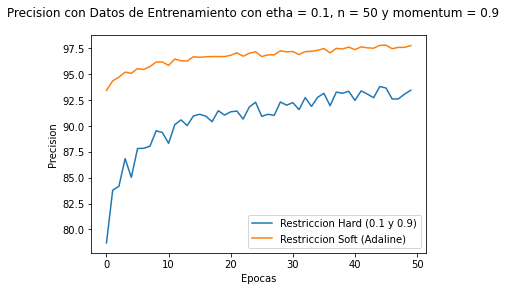

Maxima Precision Alcanzada Test Hard 91.65
Maxima Precision Alcanzada Test Soft 96.47


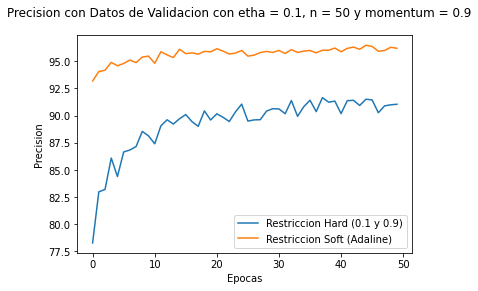

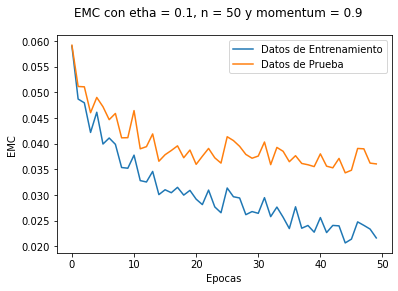

In [ ]:
import matplotlib.pyplot as plt

rna_0_1_50 = MultilayerPerceptron(-0.05, 0.05, 0.1, 0.9, 50)
rna_0_1_50.createLayer(logistic, derivateLogistic, 50, len(data_train[0]))
rna_0_1_50.createLayer(logistic, derivateLogistic, 10)
h_train, s_train, h_test, s_test, emc_train, emc_test = rna_0_1_50.trainingMain(data_train, data_test, d_function, d_scale, d_scale_soft)

#Plot Comparacion de Restricciones para Datos de Entrenamiento
print('>>> ETHA 0.1, N = 50 y MOMENTUM = 0.9')
maxPrecision_ht = np.amax(h_train)
print('Maxima Precision Alcanzada Training Hard', maxPrecision_ht)
maxPrecision_st = np.amax(s_train)
print('Maxima Precision Alcanzada Training Soft', maxPrecision_st)
plt.ylabel("Precision")
plt.xlabel("Epocas")
plt.suptitle('Precision con Datos de Entrenamiento con etha = 0.1, n = 50 y momentum = 0.9')
plt.plot(h_train, label = 'Restriccion Hard (0.1 y 0.9)')
plt.plot(s_train, label = 'Restriccion Soft (Adaline)')
plt.legend()
plt.show()

#Plot Comparacion de Restricciones para Datos de Validacion
maxPrecision_htt = np.amax(h_test)
print('Maxima Precision Alcanzada Test Hard', maxPrecision_htt)
maxPrecision_stt = np.amax(s_test)
print('Maxima Precision Alcanzada Test Soft', maxPrecision_stt)
plt.ylabel("Precision")
plt.xlabel("Epocas")
plt.suptitle('Precision con Datos de Validacion con etha = 0.1, n = 50 y momentum = 0.9')
plt.plot(h_test, label = 'Restriccion Hard (0.1 y 0.9)')
plt.plot(s_test, label = 'Restriccion Soft (Adaline)')
plt.legend()
plt.show()

#Plot Comparacion de EMC
plt.ylabel("EMC")
plt.xlabel("Epocas")
plt.suptitle('EMC con etha = 0.1, n = 50 y momentum = 0.9')
plt.plot(emc_train, label = 'Datos de Entrenamiento')
plt.plot(emc_test, label = 'Datos de Prueba')
plt.legend()
plt.show()

Epoca 1
Epoca 2
Epoca 3
Epoca 4
Epoca 5
Epoca 6
Epoca 7
Epoca 8
Epoca 9
Epoca 10
Epoca 11
Epoca 12
Epoca 13
Epoca 14
Epoca 15
Epoca 16
Epoca 17
Epoca 18
Epoca 19
Epoca 20
Epoca 21
Epoca 22
Epoca 23
Epoca 24
Epoca 25
Epoca 26
Epoca 27
Epoca 28
Epoca 29
Epoca 30
Epoca 31
Epoca 32
Epoca 33
Epoca 34
Epoca 35
Epoca 36
Epoca 37
Epoca 38
Epoca 39
Epoca 40
Epoca 41
Epoca 42
Epoca 43
Epoca 44
Epoca 45
Epoca 46
Epoca 47
Epoca 48
Epoca 49
Epoca 50
>>> ETHA 0.1, N = 100 y MOMENTUM = 0.9
Maxima Precision Alcanzada Training Hard 95.21833333333333
Maxima Precision Alcanzada Training Soft 98.19


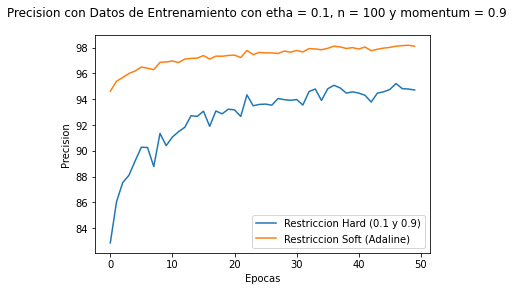

Maxima Precision Alcanzada Test Hard 93.52
Maxima Precision Alcanzada Test Soft 97.0


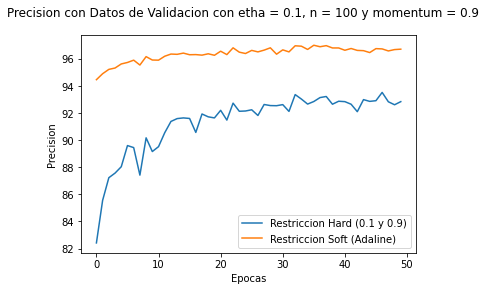

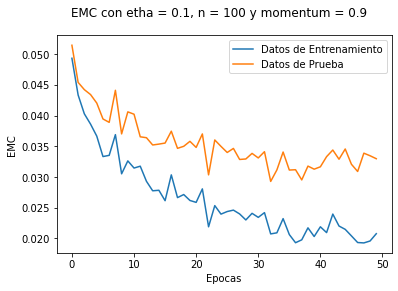

In [ ]:
import matplotlib.pyplot as plt

rna_0_1_100 = MultilayerPerceptron(-0.05, 0.05, 0.1, 0.9, 50)
rna_0_1_100.createLayer(logistic, derivateLogistic, 100, len(data_train[0]))
rna_0_1_100.createLayer(logistic, derivateLogistic, 10)
h_train, s_train, h_test, s_test, emc_train, emc_test = rna_0_1_100.trainingMain(data_train, data_test, d_function, d_scale, d_scale_soft)

#Plot Comparacion de Restricciones para Datos de Entrenamiento
print('>>> ETHA 0.1, N = 100 y MOMENTUM = 0.9')
maxPrecision_ht = np.amax(h_train)
print('Maxima Precision Alcanzada Training Hard', maxPrecision_ht)
maxPrecision_st = np.amax(s_train)
print('Maxima Precision Alcanzada Training Soft', maxPrecision_st)
plt.ylabel("Precision")
plt.xlabel("Epocas")
plt.suptitle('Precision con Datos de Entrenamiento con etha = 0.1, n = 100 y momentum = 0.9')
plt.plot(h_train, label = 'Restriccion Hard (0.1 y 0.9)')
plt.plot(s_train, label = 'Restriccion Soft (Adaline)')
plt.legend()
plt.show()

#Plot Comparacion de Restricciones para Datos de Validacion
maxPrecision_htt = np.amax(h_test)
print('Maxima Precision Alcanzada Test Hard', maxPrecision_htt)
maxPrecision_stt = np.amax(s_test)
print('Maxima Precision Alcanzada Test Soft', maxPrecision_stt)
plt.ylabel("Precision")
plt.xlabel("Epocas")
plt.suptitle('Precision con Datos de Validacion con etha = 0.1, n = 100 y momentum = 0.9')
plt.plot(h_test, label = 'Restriccion Hard (0.1 y 0.9)')
plt.plot(s_test, label = 'Restriccion Soft (Adaline)')
plt.legend()
plt.show()

#Plot Comparacion de EMC
plt.ylabel("EMC")
plt.xlabel("Epocas")
plt.suptitle('EMC con etha = 0.1, n = 100 y momentum = 0.9')
plt.plot(emc_train, label = 'Datos de Entrenamiento')
plt.plot(emc_test, label = 'Datos de Prueba')
plt.legend()
plt.show()

![Experimento 1](
https://drive.google.com/uc?id=1EqENiyZqlvVuz8GmZvB-mNo3mRU9aTUl)

En este experimento podemos observar mediante el aumento de las neuronas por cada red entrenada que la precisión mejora y el error cuadrático medio disminuye para un $\eta=0.1$ y un $\alpha = 0.9$ (momentum). Para $\eta = 20$ para la restricción que hemos considerado como Hard, llegó a conseguir una precisión del 89.27% durante el entrenamiento, siento esta el menor valor de todos las redes probadas y aun asi supera la mejor precisión conseguida con adaline con la restricción de soft. Ahora, la que realmente importa en nuestras observaciones es la precisión conseguida por los datos de validación cuyo valor menor fue 88.22% para la restricción hard, siendo aun así mas precisa que la mejor red conseguida con el adaline. En este experimento se consiguió la mejor precisión para la restricción hard con n = 100 en los datos de validación de todos las redes probada en esta tarea, siendo el valor de la misma de 93.52%.

Aunque para una red, mayor numero de neuronas no garantiza una mejora en la eficiencia de la misma, en este caso para los datos de entrenamiento, a medida que se aumentaba el número de neuronas mostraba una mejor precisión (así fuese mínima) y para los datos de validación la eficacia en la clasificación de los datos fue aumentando en mayor variación, demostrando muy buenos resultados hasta los momentos para los algoritmos que hemos implementado. En cuanto a los errores cometidos por la red pudimos observar que ya con un numero de neuronas mayor a 50 el error no varió casi, pero en comparación con la red con 20 neuronas en su capa oculta, aumentar el número de neuronas demostró una mejoría en el error cuadrático medio.

## Parte 3: Experimento 2
Con n = 100 y η = 0.1, realice entrenamientos para α = 0, 0.25, y 0.5. Compare el entrenamiento con respecto al experimento 1 en relacion a los errrores, numero de epocas para entrenar y cualquier indicio de sobre-entrenamiento.

Epoca 1
Epoca 2
Epoca 3
Epoca 4
Epoca 5
Epoca 6
Epoca 7
Epoca 8
Epoca 9
Epoca 10
Epoca 11
Epoca 12
Epoca 13
Epoca 14
Epoca 15
Epoca 16
Epoca 17
Epoca 18
Epoca 19
Epoca 20
Epoca 21
Epoca 22
Epoca 23
Epoca 24
Epoca 25
Epoca 26
Epoca 27
Epoca 28
Epoca 29
Epoca 30
Epoca 31
Epoca 32
Epoca 33
Epoca 34
Epoca 35
Epoca 36
Epoca 37
Epoca 38
Epoca 39
Epoca 40
Epoca 41
Epoca 42
Epoca 43
Epoca 44
Epoca 45
Epoca 46
Epoca 47
Epoca 48
Epoca 49
Epoca 50
>>> ETHA 0.1, N = 100 y MOMENTUM = 0
Maxima Precision Alcanzada Training Hard 97.56666666666666
Maxima Precision Alcanzada Training Soft 99.54166666666667


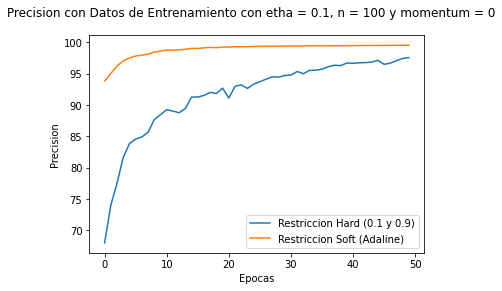

Maxima Precision Alcanzada Test Hard 91.6
Maxima Precision Alcanzada Test Soft 97.99


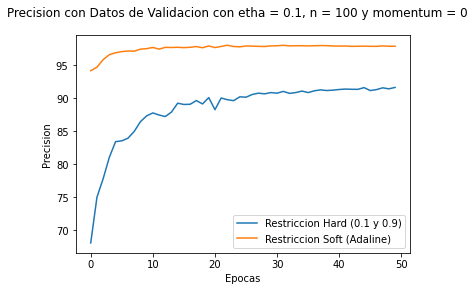

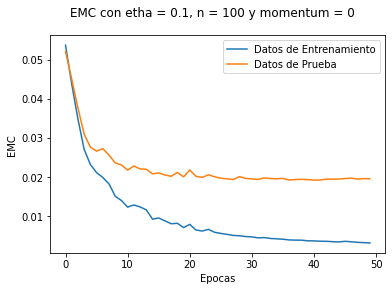

In [ ]:
import matplotlib.pyplot as plt

rna_0 = MultilayerPerceptron(-0.05, 0.05, 0.1, 0, 50)
rna_0.createLayer(logistic, derivateLogistic, 100, len(data_train[0]))
rna_0.createLayer(logistic, derivateLogistic, 10)
h_train, s_train, h_test, s_test, emc_train, emc_test = rna_0.trainingMain(data_train, data_test, d_function, d_scale, d_scale_soft)

#Plot Comparacion de Restricciones para Datos de Entrenamiento
print('>>> ETHA 0.1, N = 100 y MOMENTUM = 0')
maxPrecision_ht = np.amax(h_train)
print('Maxima Precision Alcanzada Training Hard', maxPrecision_ht)
maxPrecision_st = np.amax(s_train)
print('Maxima Precision Alcanzada Training Soft', maxPrecision_st)
plt.ylabel("Precision")
plt.xlabel("Epocas")
plt.suptitle('Precision con Datos de Entrenamiento con etha = 0.1, n = 100 y momentum = 0')
plt.plot(h_train, label = 'Restriccion Hard (0.1 y 0.9)')
plt.plot(s_train, label = 'Restriccion Soft (Adaline)')
plt.legend()
plt.show()

#Plot Comparacion de Restricciones para Datos de Validacion
maxPrecision_htt = np.amax(h_test)
print('Maxima Precision Alcanzada Test Hard', maxPrecision_htt)
maxPrecision_stt = np.amax(s_test)
print('Maxima Precision Alcanzada Test Soft', maxPrecision_stt)
plt.ylabel("Precision")
plt.xlabel("Epocas")
plt.suptitle('Precision con Datos de Validacion con etha = 0.1, n = 100 y momentum = 0')
plt.plot(h_test, label = 'Restriccion Hard (0.1 y 0.9)')
plt.plot(s_test, label = 'Restriccion Soft (Adaline)')
plt.legend()
plt.show()

#Plot Comparacion de EMC
plt.ylabel("EMC")
plt.xlabel("Epocas")
plt.suptitle('EMC con etha = 0.1, n = 100 y momentum = 0')
plt.plot(emc_train, label = 'Datos de Entrenamiento')
plt.plot(emc_test, label = 'Datos de Prueba')
plt.legend()
plt.show()

Epoca 1
Epoca 2
Epoca 3
Epoca 4
Epoca 5
Epoca 6
Epoca 7
Epoca 8
Epoca 9
Epoca 10
Epoca 11
Epoca 12
Epoca 13
Epoca 14
Epoca 15
Epoca 16
Epoca 17
Epoca 18
Epoca 19
Epoca 20
Epoca 21
Epoca 22
Epoca 23
Epoca 24
Epoca 25
Epoca 26
Epoca 27
Epoca 28
Epoca 29
Epoca 30
Epoca 31
Epoca 32
Epoca 33
Epoca 34
Epoca 35
Epoca 36
Epoca 37
Epoca 38
Epoca 39
Epoca 40
Epoca 41
Epoca 42
Epoca 43
Epoca 44
Epoca 45
Epoca 46
Epoca 47
Epoca 48
Epoca 49
Epoca 50
>>> ETHA 0.1, N = 100 y MOMENTUM = 0.25
Maxima Precision Alcanzada Training Hard 98.77
Maxima Precision Alcanzada Training Soft 99.61166666666666


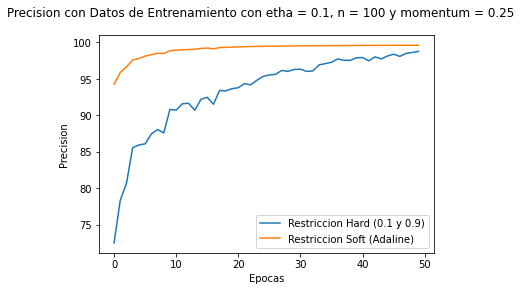

Maxima Precision Alcanzada Test Hard 91.78
Maxima Precision Alcanzada Test Soft 97.79


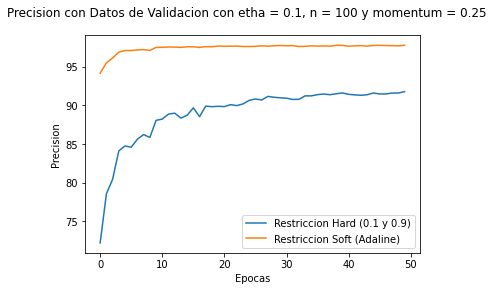

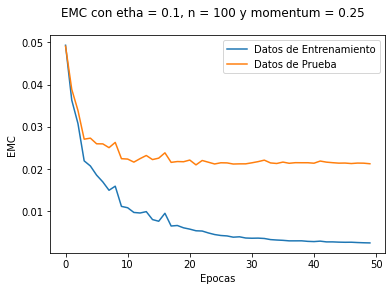

In [ ]:
import matplotlib.pyplot as plt

rna_0_25 = MultilayerPerceptron(-0.05, 0.05, 0.1, 0.25, 50)
rna_0_25.createLayer(logistic, derivateLogistic, 100, len(data_train[0]))
rna_0_25.createLayer(logistic, derivateLogistic, 10)
h_train, s_train, h_test, s_test, emc_train, emc_test = rna_0_25.trainingMain(data_train, data_test, d_function, d_scale, d_scale_soft)

#Plot Comparacion de Restricciones para Datos de Entrenamiento
print('>>> ETHA 0.1, N = 100 y MOMENTUM = 0.25')
maxPrecision_ht = np.amax(h_train)
print('Maxima Precision Alcanzada Training Hard', maxPrecision_ht)
maxPrecision_st = np.amax(s_train)
print('Maxima Precision Alcanzada Training Soft', maxPrecision_st)
plt.ylabel("Precision")
plt.xlabel("Epocas")
plt.suptitle('Precision con Datos de Entrenamiento con etha = 0.1, n = 100 y momentum = 0.25')
plt.plot(h_train, label = 'Restriccion Hard (0.1 y 0.9)')
plt.plot(s_train, label = 'Restriccion Soft (Adaline)')
plt.legend()
plt.show()

#Plot Comparacion de Restricciones para Datos de Validacion
maxPrecision_htt = np.amax(h_test)
print('Maxima Precision Alcanzada Test Hard', maxPrecision_htt)
maxPrecision_stt = np.amax(s_test)
print('Maxima Precision Alcanzada Test Soft', maxPrecision_stt)
plt.ylabel("Precision")
plt.xlabel("Epocas")
plt.suptitle('Precision con Datos de Validacion con etha = 0.1, n = 100 y momentum = 0.25')
plt.plot(h_test, label = 'Restriccion Hard (0.1 y 0.9)')
plt.plot(s_test, label = 'Restriccion Soft (Adaline)')
plt.legend()
plt.show()

#Plot Comparacion de EMC
plt.ylabel("EMC")
plt.xlabel("Epocas")
plt.suptitle('EMC con etha = 0.1, n = 100 y momentum = 0.25')
plt.plot(emc_train, label = 'Datos de Entrenamiento')
plt.plot(emc_test, label = 'Datos de Prueba')
plt.legend()
plt.show()

Epoca 1
Epoca 2
Epoca 3
Epoca 4
Epoca 5
Epoca 6
Epoca 7
Epoca 8
Epoca 9
Epoca 10
Epoca 11
Epoca 12
Epoca 13
Epoca 14
Epoca 15
Epoca 16
Epoca 17
Epoca 18
Epoca 19
Epoca 20
Epoca 21
Epoca 22
Epoca 23
Epoca 24
Epoca 25
Epoca 26
Epoca 27
Epoca 28
Epoca 29
Epoca 30
Epoca 31
Epoca 32
Epoca 33
Epoca 34
Epoca 35
Epoca 36
Epoca 37
Epoca 38
Epoca 39
Epoca 40
Epoca 41
Epoca 42
Epoca 43
Epoca 44
Epoca 45
Epoca 46
Epoca 47
Epoca 48
Epoca 49
Epoca 50
>>> ETHA 0.1, N = 100 y MOMENTUM = 0.5
Maxima Precision Alcanzada Training Hard 99.30166666666666
Maxima Precision Alcanzada Training Soft 99.59


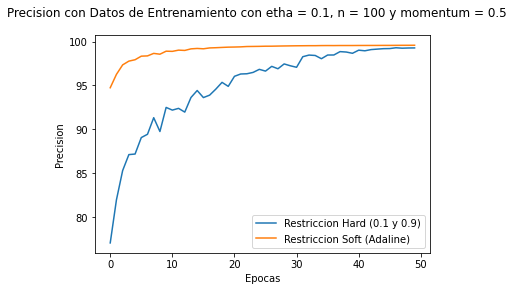

Maxima Precision Alcanzada Test Hard 91.88
Maxima Precision Alcanzada Test Soft 97.85


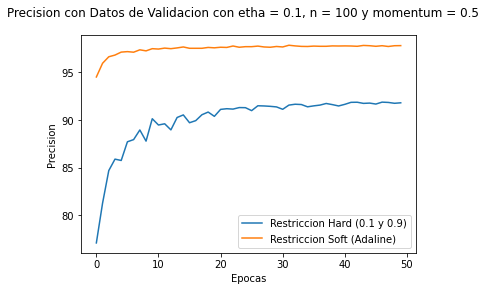

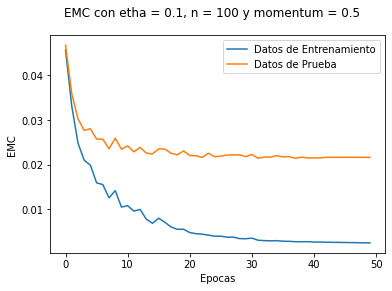

In [ ]:
import matplotlib.pyplot as plt

rna_0_5 = MultilayerPerceptron(-0.05, 0.05, 0.1, 0.5, 50)
rna_0_5.createLayer(logistic, derivateLogistic, 100, len(data_train[0]))
rna_0_5.createLayer(logistic, derivateLogistic, 10)
h_train, s_train, h_test, s_test, emc_train, emc_test = rna_0_5.trainingMain(data_train, data_test, d_function, d_scale, d_scale_soft)

#Plot Comparacion de Restricciones para Datos de Entrenamiento
print('>>> ETHA 0.1, N = 100 y MOMENTUM = 0.5')
maxPrecision_ht = np.amax(h_train)
print('Maxima Precision Alcanzada Training Hard', maxPrecision_ht)
maxPrecision_st = np.amax(s_train)
print('Maxima Precision Alcanzada Training Soft', maxPrecision_st)
plt.ylabel("Precision")
plt.xlabel("Epocas")
plt.suptitle('Precision con Datos de Entrenamiento con etha = 0.1, n = 100 y momentum = 0.5')
plt.plot(h_train, label = 'Restriccion Hard (0.1 y 0.9)')
plt.plot(s_train, label = 'Restriccion Soft (Adaline)')
plt.legend()
plt.show()

#Plot Comparacion de Restricciones para Datos de Validacion
maxPrecision_htt = np.amax(h_test)
print('Maxima Precision Alcanzada Test Hard', maxPrecision_htt)
maxPrecision_stt = np.amax(s_test)
print('Maxima Precision Alcanzada Test Soft', maxPrecision_stt)
plt.ylabel("Precision")
plt.xlabel("Epocas")
plt.suptitle('Precision con Datos de Validacion con etha = 0.1, n = 100 y momentum = 0.5')
plt.plot(h_test, label = 'Restriccion Hard (0.1 y 0.9)')
plt.plot(s_test, label = 'Restriccion Soft (Adaline)')
plt.legend()
plt.show()

#Plot Comparacion de EMC
plt.ylabel("EMC")
plt.xlabel("Epocas")
plt.suptitle('EMC con etha = 0.1, n = 100 y momentum = 0.5')
plt.plot(emc_train, label = 'Datos de Entrenamiento')
plt.plot(emc_test, label = 'Datos de Prueba')
plt.legend()
plt.show()

![Experimento 1](https://drive.google.com/uc?id=1FQingmKXrMmFwQIh68V4qIVgJ07fQgIK)

Ya fijando nuestro número de neuronas a 100 y $\eta = 0.1$, comparamos el comportamiento de la red variando el momentum en cada entrenamiento. De manera similar al experimento 1, ha medida que se aumentaba el momentum la red alcanzaba durante el calculo de la precisión del entrenamiento picos altos en su desarrollo, siendo el mejor de ellos con $\alpha = 0.50$ con una precisión de 99.3% para restricción hard y 99.59% con restricción soft para los datos de Entrenamiento. Con respecto a los datos de validación también mejoraba minimamente a medida que se aumentaba el momentum, pero estos valores se mantuvieron constante siendo su variación maxima 22 decimas. De igual manera con el $\alpha = 0$ se consiguió la red con mejor precisión para los datos de validación para todas las redes probadas con restricción soft, siendo esta de 97.99%. En cuanto al error cuadrático medio cometido por las redes fue minimo para ambos tipos de datos.

En comparación al experimento 1, se demostró que con un momemtum menor se pueden obtener mejores resultados. Se obtuvo una mejor precisión para ambos datos y una disminución en el error cuadrático medio, siendo relativamente pequeños los cambios pero no dejan de ser significativos para la mejora de la red.

## Parte 4: Experimento 3
Fije n a 100, α = 0.9. Entrene dos redes. La primera red se entrenara con 1/4 del conjunto de entrenamiento y la segunda con la mitad del conjunto de entrenamiento (asegurese en cada caso estar tomando datos de las 10 clases). Comente sus resultados en relacion al experimento 1.

In [ ]:
import numpy as np

def ratio_data(data, ratio):
  '''
    {Funcion ratio_data}
      Metodo que recibe un arreglo de datos y los particiona en base a la 
      proporcion indicada, asegurandose que existe un dato de cada clase

    INPUT: data      -> Arreglo con datos
           ratio     -> Proporcion a particionar
    
    OUTPUR: new_data -> Arreglo particionado
            verify   -> Arreglo que indica la proporcion por valor de cada clase
  '''
  verify = [0,0,0,0,0,0,0,0,0,0]
  all_class = False
  while all_class == False:
    new_data = []
    np.random.shuffle(data)
    for x in range(int(len(data)*ratio)):
      verify[int(data[x][0])] += 1
      new_data.append(data[x])
    all_class = True
    for i in verify:
      if i == 0:
        all_class = False
  return new_data, verify

Distribucion de los Datos
Clase [0]: 1455 datos
Clase [1]: 1694 datos
Clase [2]: 1464 datos
Clase [3]: 1588 datos
Clase [4]: 1402 datos
Clase [5]: 1409 datos
Clase [6]: 1482 datos
Clase [7]: 1556 datos
Clase [8]: 1471 datos
Clase [9]: 1479 datos
Epoca 1
Epoca 2
Epoca 3
Epoca 4
Epoca 5
Epoca 6
Epoca 7
Epoca 8
Epoca 9
Epoca 10
Epoca 11
Epoca 12
Epoca 13
Epoca 14
Epoca 15
Epoca 16
Epoca 17
Epoca 18
Epoca 19
Epoca 20
Epoca 21
Epoca 22
Epoca 23
Epoca 24
Epoca 25
Epoca 26
Epoca 27
Epoca 28
Epoca 29
Epoca 30
Epoca 31
Epoca 32
Epoca 33
Epoca 34
Epoca 35
Epoca 36
Epoca 37
Epoca 38
Epoca 39
Epoca 40
Epoca 41
Epoca 42
Epoca 43
Epoca 44
Epoca 45
Epoca 46
Epoca 47
Epoca 48
Epoca 49
Epoca 50
>>> ETHA 0.1, N = 100 y MOMENTUM = 0.9 para 1/4 de Datos Training
Maxima Precision Alcanzada Training Hard 99.09333333333333
Maxima Precision Alcanzada Training Soft 99.18


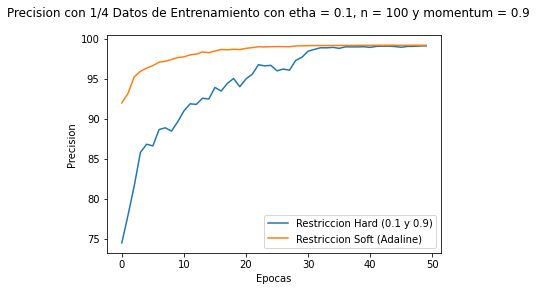

Maxima Precision Alcanzada Test Hard 90.98
Maxima Precision Alcanzada Test Soft 96.43


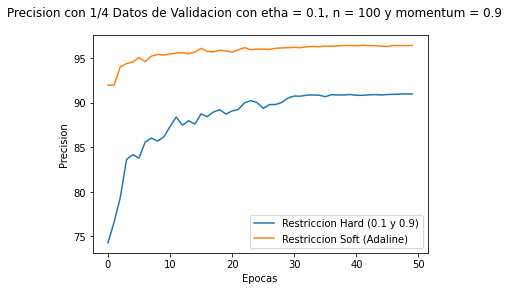

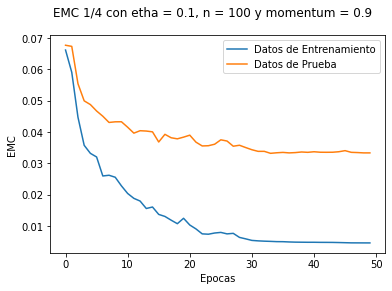

In [ ]:
import matplotlib.pyplot as plt

new_data_train, proportion = ratio_data(data_train, 1/4)

print('Distribucion de los Datos')
j = 0
for i in proportion:
  print('Clase ['+ str(j) +']: ' +str(i)+ ' datos')
  j += 1

rna_1_4 = MultilayerPerceptron(-0.05, 0.05, 0.1, 0.9, 50)
rna_1_4.createLayer(logistic, derivateLogistic, 100, len(new_data_train[0]))
rna_1_4.createLayer(logistic, derivateLogistic, 10)
h_train, s_train, h_test, s_test, emc_train, emc_test = rna_1_4.trainingMain(new_data_train, data_test, d_function, d_scale, d_scale_soft)

#Plot Comparacion de Restricciones para Datos de Entrenamiento
print('>>> ETHA 0.1, N = 100 y MOMENTUM = 0.9 para 1/4 de Datos Training')
maxPrecision_ht = np.amax(h_train)
print('Maxima Precision Alcanzada Training Hard', maxPrecision_ht)
maxPrecision_st = np.amax(s_train)
print('Maxima Precision Alcanzada Training Soft', maxPrecision_st)
plt.ylabel("Precision")
plt.xlabel("Epocas")
plt.suptitle('Precision con 1/4 Datos de Entrenamiento con etha = 0.1, n = 100 y momentum = 0.9')
plt.plot(h_train, label = 'Restriccion Hard (0.1 y 0.9)')
plt.plot(s_train, label = 'Restriccion Soft (Adaline)')
plt.legend()
plt.show()

#Plot Comparacion de Restricciones para Datos de Validacion
maxPrecision_htt = np.amax(h_test)
print('Maxima Precision Alcanzada Test Hard', maxPrecision_htt)
maxPrecision_stt = np.amax(s_test)
print('Maxima Precision Alcanzada Test Soft', maxPrecision_stt)
plt.ylabel("Precision")
plt.xlabel("Epocas")
plt.suptitle('Precision con 1/4 Datos de Validacion con etha = 0.1, n = 100 y momentum = 0.9')
plt.plot(h_test, label = 'Restriccion Hard (0.1 y 0.9)')
plt.plot(s_test, label = 'Restriccion Soft (Adaline)')
plt.legend()
plt.show()

#Plot Comparacion de EMC
plt.ylabel("EMC")
plt.xlabel("Epocas")
plt.suptitle('EMC 1/4 con etha = 0.1, n = 100 y momentum = 0.9')
plt.plot(emc_train, label = 'Datos de Entrenamiento')
plt.plot(emc_test, label = 'Datos de Prueba')
plt.legend()
plt.show()

Distribucion de los Datos
Clase [0]: 3005 datos
Clase [1]: 3333 datos
Clase [2]: 3007 datos
Clase [3]: 3065 datos
Clase [4]: 2942 datos
Clase [5]: 2746 datos
Clase [6]: 2905 datos
Clase [7]: 3138 datos
Clase [8]: 2893 datos
Clase [9]: 2966 datos
Epoca 1
Epoca 2
Epoca 3
Epoca 4
Epoca 5
Epoca 6
Epoca 7
Epoca 8
Epoca 9
Epoca 10
Epoca 11
Epoca 12
Epoca 13
Epoca 14
Epoca 15
Epoca 16
Epoca 17
Epoca 18
Epoca 19
Epoca 20
Epoca 21
Epoca 22
Epoca 23
Epoca 24
Epoca 25
Epoca 26
Epoca 27
Epoca 28
Epoca 29
Epoca 30
Epoca 31
Epoca 32
Epoca 33
Epoca 34
Epoca 35
Epoca 36
Epoca 37
Epoca 38
Epoca 39
Epoca 40
Epoca 41
Epoca 42
Epoca 43
Epoca 44
Epoca 45
Epoca 46
Epoca 47
Epoca 48
Epoca 49
Epoca 50
>>> ETHA 0.1, N = 100 y MOMENTUM = 0.9 para 1/2 de Datos Training
Maxima Precision Alcanzada Training Hard 97.78
Maxima Precision Alcanzada Training Soft 99.31333333333333


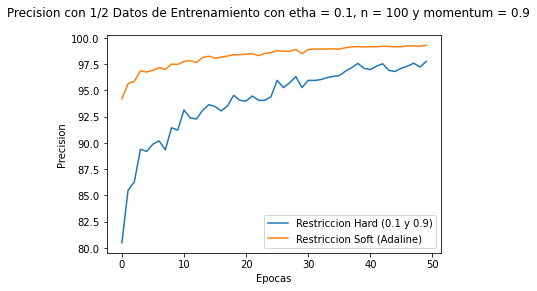

Maxima Precision Alcanzada Test Hard 93.05
Maxima Precision Alcanzada Test Soft 97.03


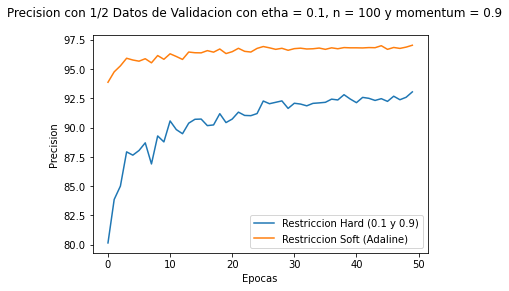

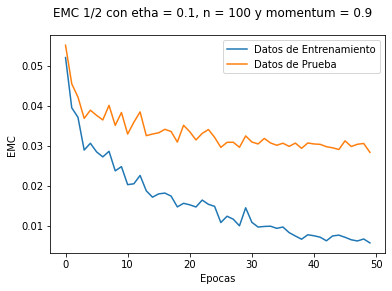

In [ ]:
import matplotlib.pyplot as plt

new_data_train, proportion = ratio_data(data_train, 1/2)

print('Distribucion de los Datos')
j = 0
for i in proportion:
  print('Clase ['+str(j)+']: ' +str(i)+ ' datos')
  j += 1

rna_1_2 = MultilayerPerceptron(-0.05, 0.05, 0.1, 0.9, 50)
rna_1_2.createLayer(logistic, derivateLogistic, 100, len(new_data_train[0]))
rna_1_2.createLayer(logistic, derivateLogistic, 10)
h_train, s_train, h_test, s_test, emc_train, emc_test = rna_1_2.trainingMain(new_data_train, data_test, d_function, d_scale, d_scale_soft)

#Plot Comparacion de Restricciones para Datos de Entrenamiento
print('>>> ETHA 0.1, N = 100 y MOMENTUM = 0.9 para 1/2 de Datos Training')
maxPrecision_ht = np.amax(h_train)
print('Maxima Precision Alcanzada Training Hard', maxPrecision_ht)
maxPrecision_st = np.amax(s_train)
print('Maxima Precision Alcanzada Training Soft', maxPrecision_st)
plt.ylabel("Precision")
plt.xlabel("Epocas")
plt.suptitle('Precision con 1/2 Datos de Entrenamiento con etha = 0.1, n = 100 y momentum = 0.9')
plt.plot(h_train, label = 'Restriccion Hard (0.1 y 0.9)')
plt.plot(s_train, label = 'Restriccion Soft (Adaline)')
plt.legend()
plt.show()

#Plot Comparacion de Restricciones para Datos de Validacion
maxPrecision_htt = np.amax(h_test)
print('Maxima Precision Alcanzada Test Hard', maxPrecision_htt)
maxPrecision_stt = np.amax(s_test)
print('Maxima Precision Alcanzada Test Soft', maxPrecision_stt)
plt.ylabel("Precision")
plt.xlabel("Epocas")
plt.suptitle('Precision con 1/2 Datos de Validacion con etha = 0.1, n = 100 y momentum = 0.9')
plt.plot(h_test, label = 'Restriccion Hard (0.1 y 0.9)')
plt.plot(s_test, label = 'Restriccion Soft (Adaline)')
plt.legend()
plt.show()

#Plot Comparacion de EMC
plt.ylabel("EMC")
plt.xlabel("Epocas")
plt.suptitle('EMC 1/2 con etha = 0.1, n = 100 y momentum = 0.9')
plt.plot(emc_train, label = 'Datos de Entrenamiento')
plt.plot(emc_test, label = 'Datos de Prueba')
plt.legend()
plt.show()

![Experimento 1](https://drive.google.com/uc?id=1ArrDlEH69VgB2FM3CU6n3Ovi3zyOxN2R)

En este experimento es dificil comparar los resultados de ambas redes debido a que mientras para uno tuvo mejores resultados para la restricción hard, la otra lo tuvo para la restricción soft para los datos de entrenamiento. En cuanto a los datos de validación, el resultado fue mejor para la red que entrenó con la mitad de los datos en cuanto a precisión se refiere, para ambas restricciones. Al igual que para el ECM, en los datos de validación se obtuvo un menor error para la mitad de los datos.

Comparándolo con el experimento 1, con la red que tenía la misma cantidad de neuronas, el mismo $\eta$ y el mismo momentum, se pudo ver que obtuvo resultados muy, pero muy parecidos para la mitad de los datos, dejando ver que puede existir un posible sobreentrenamiento en las red sin dimensionar los datos para esta configuración de red.